In [112]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import imblearn

Importing data corresponding to the 2008 financial collapse

In [113]:
bns = pd.read_csv(os.getcwd()+'/stockdata/BNS.TO-(2007,2010).csv')
td = pd.read_csv(os.getcwd()+'/stockdata/TD.TO-(2007,2010).csv')
bmo = pd.read_csv(os.getcwd()+'/stockdata/BMO-(2007,2010).csv')
cibc = pd.read_csv(os.getcwd()+'/stockdata/CM.TO-(2007,2010).csv')
rbc = pd.read_csv(os.getcwd()+'/stockdata/RY.TO-(2007,2010).csv')

Importing data corresponding to mid-february when the stocks fell

In [3]:
bns0 = pd.read_csv(os.getcwd()+'/stockdata/BNS.TO-(2020,2020).csv')
td0 = pd.read_csv(os.getcwd()+'/stockdata/TD.TO-(2020,2020).csv')
bmo0 = pd.read_csv(os.getcwd()+'/stockdata/BMO-(2020,2020).csv')
cibc0 = pd.read_csv(os.getcwd()+'/stockdata/CM.TO-(2020,2020).csv')
rbc0 = pd.read_csv(os.getcwd()+'/stockdata/RY.TO-(2020,2020).csv')

In [4]:
stocks = [bns, td, bmo, cibc, rbc]
stocks0 = [bns0, td0, bmo0, cibc0, rbc0]

In [5]:
for stock in stocks:
    stock['Normalized Adj. Close'] = scale(stock['Adj. Close'])
for stock in stocks0:
    stock['Normalized Adj. Close'] = scale(stock['Adj. Close'])

Plotting the drop points for comparison's sake

In [6]:
numpied = [stock['Normalized Adj. Close'][425:500].to_numpy() for stock in stocks]
numpied0 = [stock['Normalized Adj. Close'].to_numpy() for stock in stocks0]

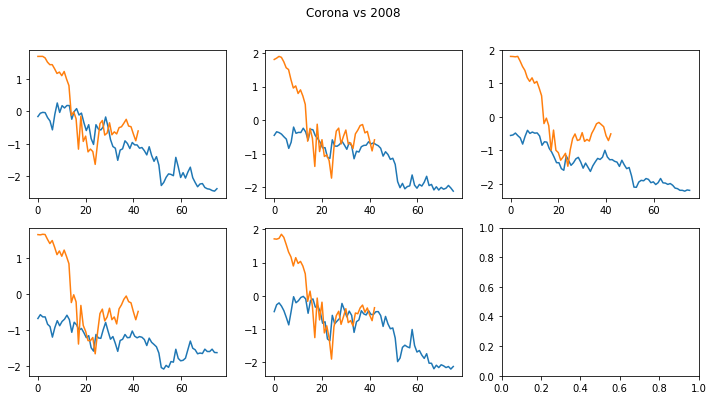

In [7]:
fig, axs = plt.subplots(2,3, figsize = (12,6))
fig.suptitle("Corona vs 2008")
n=0
for i in range(2):
    for j in range(3):
        if ((i+1)*(1+j))>5:
            break 
        axs[i][j].plot(np.linspace(0,75,75), numpied[n], numpied0[n])
        n+=1

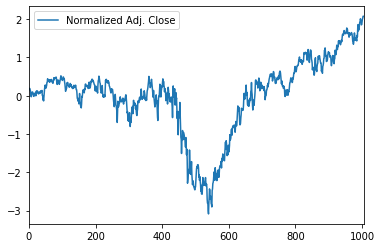

In [8]:
bns.plot(x=None, y='Normalized Adj. Close')

# Import the trusty epoch function and start preprocessing

In [9]:
def epoch(signal, window_size, inter_window_interval):
    num_windows = 1 + (len(signal) - window_size) // inter_window_interval

    epochs = []
    for i in range(num_windows):
        epochs.append(signal[i*inter_window_interval:i*inter_window_interval + window_size])

    return np.array(epochs)

In [10]:
from sklearn.linear_model import LinearRegression
def get_slope(data):
    days = np.linspace(0,len(data), len(data)).reshape((-1,1))
    reg = LinearRegression().fit(days, data.reshape((-1,1)))
    return reg.coef_.flatten()

In [254]:
epoched = np.array([epoch(stock['Normalized Adj. Close'].to_numpy(), 10, 10) for stock in stocks])
slopes = np.array([np.array([get_slope(datum) for datum in data]) for data in epoched])

In [255]:
print(epoched.shape)
print(slopes.shape)
print(get_slope(epoched[2][34]))
print(slopes[2][34])

(5, 100, 10)
(5, 100, 1)
[0.00480031]
[0.00480031]


1002

In [218]:
def generate_label(data, mean, std):
    if data>=mean+std:
        return int(1)
    if data<=mean-std:
        return int(-1)
    else:
        return int(0)

In [256]:
std = np.std(slopes.flatten())
mean = np.mean(slopes.flatten())

labels = np.array([[generate_label(datum, mean, std) for datum in data] for data in slopes])

In [257]:
labels.shape

(5, 100)

In [258]:
shifted_labels = labels.flatten()[1:]
samples = epoched.reshape((500,10))[:-1]

In [259]:
print(shifted_labels.shape)
print(samples.shape)

(499,)
(499, 10)


# Quick Model, no sampling done 

In [83]:
import keras 
from sklearn.model_selection import train_test_split
from keras import Sequential, models
from keras.layers import Dense, Activation

In [260]:
y = keras.utils.to_categorical(shifted_labels, num_classes=3)
x = samples.reshape(499,10)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7)

In [265]:
#ad hoc
model = Sequential()
model.add(Dense(6, input_dim=10))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))

In [266]:
#model.summary()

In [267]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [268]:
model.fit(x_train, y_train, batch_size=1, epochs = 10, validation_data=(x_test,y_test))

Train on 349 samples, validate on 150 samples
Epoch 1/10
349/349 [==============================] - 1s 2ms/step - loss: 0.9500 - accuracy: 0.6963 - val_loss: 0.8762 - val_accuracy: 0.7200
Epoch 2/10
349/349 [==============================] - 1s 2ms/step - loss: 0.7961 - accuracy: 0.7278 - val_loss: 0.8488 - val_accuracy: 0.7200
Epoch 3/10
349/349 [==============================] - 1s 2ms/step - loss: 0.7724 - accuracy: 0.7278 - val_loss: 0.8140 - val_accuracy: 0.7200
Epoch 4/10
349/349 [==============================] - 1s 2ms/step - loss: 0.7786 - accuracy: 0.7278 - val_loss: 0.8128 - val_accuracy: 0.7200
Epoch 5/10
349/349 [==============================] - 1s 2ms/step - loss: 0.7593 - accuracy: 0.7278 - val_loss: 0.8525 - val_accuracy: 0.7200
Epoch 6/10
349/349 [==============================] - 1s 2ms/step - loss: 0.7641 - accuracy: 0.7278 - val_loss: 0.7935 - val_accuracy: 0.7200
Epoch 7/10
349/349 [==============================] - 1s 2ms/step - loss: 0.7572 - accuracy: 0.7278 - 

In [273]:
np.where(shifted_labels==1)[0]

array([  3,  34,  42,  49,  54,  56,  59,  61,  63,  65,  70,  77,  78,
        81,  87,  97, 115, 117, 149, 154, 155, 156, 159, 161, 165, 170,
       178, 179, 181, 187, 191, 217, 229, 249, 257, 259, 262, 263, 265,
       277, 278, 281, 284, 287, 288, 291, 308, 329, 332, 347, 349, 354,
       356, 361, 362, 363, 377, 378, 387, 403, 442, 449, 454, 456, 461,
       463, 465, 477, 481, 487, 491])

In [274]:
i=3
test = samples[i].flatten().reshape(1,10)

In [275]:
print(model.predict(test))
print(y[i])

[[0.7897182  0.10404605 0.10623577]]
[0. 1. 0.]


Notes from above, usually predicts a "do nothing" signal. Maybe this is due to the unbalanced dataset

# SMOTE approach

In [180]:
from imblearn.over_sampling import SMOTE

In [276]:
sm = SMOTE(sampling_strategy='not majority')   #for some reason the ratio won't work
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [277]:
model.fit(x_train_res, y_train_res, batch_size=1, epochs = 10, validation_data=(x_test,y_test))

Train on 762 samples, validate on 150 samples
Epoch 1/10
762/762 [==============================] - 1s 1ms/step - loss: 1.1212 - accuracy: 0.3990 - val_loss: 1.0238 - val_accuracy: 0.6133
Epoch 2/10
762/762 [==============================] - 1s 1ms/step - loss: 1.0751 - accuracy: 0.4068 - val_loss: 1.0995 - val_accuracy: 0.5467
Epoch 3/10
762/762 [==============================] - 1s 1ms/step - loss: 1.0714 - accuracy: 0.4042 - val_loss: 1.1018 - val_accuracy: 0.5400
Epoch 4/10
762/762 [==============================] - 1s 1ms/step - loss: 1.0713 - accuracy: 0.4016 - val_loss: 1.1107 - val_accuracy: 0.4867
Epoch 5/10
762/762 [==============================] - 1s 1ms/step - loss: 1.0669 - accuracy: 0.4160 - val_loss: 1.0755 - val_accuracy: 0.5600
Epoch 6/10
762/762 [==============================] - 1s 1ms/step - loss: 1.0652 - accuracy: 0.4199 - val_loss: 1.1427 - val_accuracy: 0.4667
Epoch 7/10
762/762 [==============================] - 1s 1ms/step - loss: 1.0635 - accuracy: 0.4147 - 

In [282]:
np.argmax(model.predict(samples[49].reshape(1,10)))

1